In [91]:
import sys
sys.path.append("../")

from torchvision.models.detection import retinanet_resnet50_fpn_v2, RetinaNet_ResNet50_FPN_V2_Weights
from torchvision.models.detection.retinanet import RetinaNetClassificationHead
import torch
import functools
from RGBNeonDataset import RGBNEONTreeDataset
from torch.utils.data import DataLoader
import numpy as np

import time

In [92]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")


In [93]:
num_classes = 1 # Tree and background

model = retinanet_resnet50_fpn_v2(weights=RetinaNet_ResNet50_FPN_V2_Weights.COCO_V1, device=device)
# replace classification layer 
num_anchors = model.head.classification_head.num_anchors

model.head.classification_head = RetinaNetClassificationHead(
        in_channels=256,
        num_anchors=num_anchors,
        num_classes=num_classes,
        norm_layer=functools.partial(torch.nn.GroupNorm, 32)
    )

# Freeze the FPN backbone
for param in model.backbone.parameters():
    param.requires_grad = False

model.train()
model.to(device)

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [94]:
NUM_EPOCHS = 80
BATCH_SIZE = 8
LEARNING_RATE = 1e-6 # 1e-6 too large

In [95]:
dataset = DataLoader(RGBNEONTreeDataset("/Users/ishirgarg/Github/UAV_Playground/NEON/single_evaluation", "/Users/ishirgarg/Github/UAV_Playground/NEON/annotations"), batch_size=BATCH_SIZE, shuffle=True, collate_fn= lambda x : x)

optimizer = torch.optim.Adam(model.parameters(), LEARNING_RATE)
loss_history = []

for epoch in range(NUM_EPOCHS):
    print(f"Starting epoch {epoch}")
    running_loss = 0.0

    for (i, data) in enumerate(dataset):
        print(f"Started batch {i}")
        images = [torch.Tensor(pair["rgb"][:,:,::-1].transpose((2, 0, 1)) / 255).to(device) for pair in data]
        annotations = [{
            "boxes": torch.Tensor(pair["annotation"]).to(device),
            "labels": torch.Tensor([0] * len(pair["annotation"])).long().to(device)
        } for pair in data]

        optimizer.zero_grad()

        loss_dict = model(images, annotations)
        losses = sum(loss for loss in loss_dict.values())

        running_loss += losses

        losses.backward()

        # Adjust learning weights
        optimizer.step()

    loss_history.append(running_loss)
    
print(loss_history)
torch.save(model.state_dict(), "./m.pt")


Starting epoch 0
Started batch 0
Starting epoch 1
Started batch 0
Starting epoch 2
Started batch 0
Starting epoch 3
Started batch 0
Starting epoch 4
Started batch 0
Starting epoch 5
Started batch 0
Starting epoch 6
Started batch 0
Starting epoch 7
Started batch 0
Starting epoch 8
Started batch 0
Starting epoch 9
Started batch 0
Starting epoch 10
Started batch 0
Starting epoch 11
Started batch 0
Starting epoch 12
Started batch 0
Starting epoch 13
Started batch 0
Starting epoch 14
Started batch 0
Starting epoch 15
Started batch 0
Starting epoch 16
Started batch 0
Starting epoch 17
Started batch 0
Starting epoch 18
Started batch 0
Starting epoch 19
Started batch 0
Starting epoch 20
Started batch 0
Starting epoch 21
Started batch 0
Starting epoch 22
Started batch 0
Starting epoch 23
Started batch 0
Starting epoch 24
Started batch 0
Starting epoch 25
Started batch 0
Starting epoch 26
Started batch 0
Starting epoch 27
Started batch 0
Starting epoch 28
Started batch 0
Starting epoch 29
Starte

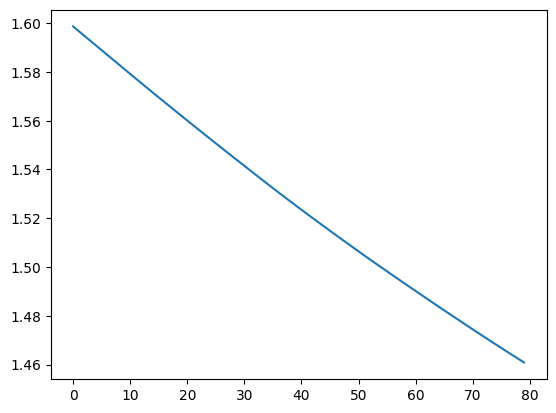

In [96]:
import matplotlib.pyplot as plt
plt.plot([loss.item() for loss in loss_history])
plt.show()